<a href="https://colab.research.google.com/github/KhawajaAbaid/medium-articles/blob/main/GAN_in_Keras_3_with_JAX_backend.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Make sure we're using Keras 3
!pip install --upgrade keras

In [ ]:
# Make sure to set the environment variable before import keras
import os
os.environ["KERAS_BACKEND"] = "jax"

In [ ]:
import keras
from keras import layers, ops, random, datasets
import jax
import jax.numpy as jnp
import tensorflow as tf
import time

# Download and prepare dataset

In [ ]:
BATCH_SIZE = 256

In [ ]:
(mnist_training_data, _), (_, _) = datasets.mnist.load_data()

In [ ]:
# scale the data to [-1, 1] range
# Since the original values are in range [0, 255],
# so to scale the values to [-1, 1]
# we first subtract 255/2=127.5 and then divide by it as well
mnist_training_data = (mnist_training_data - 127.5) / 127.5

NUM_SAMPLES = len(mnist_training_data)

# convert it into a tensorflow dataset
mnist_dataset = tf.data.Dataset.from_tensor_slices(mnist_training_data).batch(BATCH_SIZE).shuffle(NUM_SAMPLES)

# Define and instantiate models

In [ ]:
def get_generator(image_shape: tuple = (28, 28, 1),
                    latent_dim: int = 100):
  inputs = layers.Input(shape=(latent_dim,), name="generator_input")
  x = layers.Dense(256)(inputs)
  x = layers.LeakyReLU(negative_slope=0.2)(x)
  x = layers.BatchNormalization(momentum=0.5)(x)
  x = layers.Dense(512)(x)
  x = layers.LeakyReLU(negative_slope=0.2)(x)
  x = layers.BatchNormalization(momentum=0.5)(x)
  x = layers.Dense(1024)(x)
  x = layers.LeakyReLU(negative_slope=0.2)(x)
  x = layers.BatchNormalization(momentum=0.5)(x)
  x = layers.Dense(ops.prod(jnp.array(image_shape)).item(), activation="tanh")(x)
  outputs = layers.Reshape(image_shape, name="generator_output")(x)

  return keras.Model(inputs, outputs, name="generator")


In [ ]:
def get_discriminator(image_shape: tuple = (28, 28, 1)):
  inputs = layers.Input(shape=image_shape, name="discriminator_input")
  x = layers.Flatten()(inputs)
  x = layers.Dense(512)(x)
  x = layers.LeakyReLU(negative_slope=0.2)(x)
  x = layers.Dense(256)(x)
  x = layers.LeakyReLU(negative_slope=0.2)(x)
  x = layers.Dense(128)(x)
  x = layers.LeakyReLU(negative_slope=0.2)(x)
  outputs = layers.Dense(1, activation="sigmoid",
                         name="discriminator_output")(x)

  return keras.Model(inputs, outputs, name="discriminator")


In [ ]:
generator = get_generator()
discriminator = get_discriminator()

## Print model summaries
Great way to analyzing
- how layers transform input shapes
- and how much parameters each layer user

In [ ]:
get_generator().summary()

Model: "generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Layer (type)                       ┃ Output Shape                  ┃     Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ generator_input (InputLayer)       │ (None, 100)                   │           0 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ dense_7 (Dense)                    │ (None, 256)                   │      25,856 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ leaky_re_lu_6 (LeakyReLU)          │ (None, 256)                   │           0 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ batch_normalization_3              │ (None, 256)                   │       1,024 │
│ (BatchNormalization)               │                               │             │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ dense_8 (Dense)                    │ (None, 512)                   │     131,584 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ leaky_re_lu_7 (LeakyReLU)          │ (None, 512)                   │           0 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ batch_normalization_4              │ (None, 512)                   │       2,048 │
│ (BatchNormalization)               │                               │             │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ dense_9 (Dense)                    │ (None, 1024)                  │     525,312 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ leaky_re_lu_8 (LeakyReLU)          │ (None, 1024)                  │           0 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ batch_normalization_5              │ (None, 1024)                  │       4,096 │
│ (BatchNormalization)               │                               │             │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ dense_10 (Dense)                   │ (None, 784)                   │     803,600 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ generator_output (Reshape)         │ (None, 28, 28, 1)             │           0 │
└────────────────────────────────────┴───────────────────────────────┴─────────────┘

 Total params: 1,493,520 (5.70 MB)

 Trainable params: 1,489,936 (5.68 MB)

 Non-trainable params: 3,584 (14.00 KB)

In [ ]:
get_discriminator().summary()

Model: "discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Layer (type)                       ┃ Output Shape                  ┃     Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ discriminator_input (InputLayer)   │ (None, 28, 28, 1)             │           0 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ flatten_1 (Flatten)                │ (None, 784)                   │           0 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ dense_11 (Dense)                   │ (None, 512)                   │     401,920 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ leaky_re_lu_9 (LeakyReLU)          │ (None, 512)                   │           0 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ dense_12 (Dense)                   │ (None, 256)                   │     131,328 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ leaky_re_lu_10 (LeakyReLU)         │ (None, 256)                   │           0 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ dense_13 (Dense)                   │ (None, 128)                   │      32,896 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ leaky_re_lu_11 (LeakyReLU)         │ (None, 128)                   │           0 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ discriminator_output (Dense)       │ (None, 1)                     │         129 │
└────────────────────────────────────┴───────────────────────────────┴─────────────┘

 Total params: 566,273 (2.16 MB)

 Trainable params: 566,273 (2.16 MB)

 Non-trainable params: 0 (0.00 B)

# Define loss function and optimizers

In [ ]:
loss_fn = keras.losses.BinaryCrossentropy()

generator_optimizer = keras.optimizers.Adam(learning_rate=0.0002,
                                            beta_1=0.5)
discriminator_optimizer = keras.optimizers.Adam(learning_rate=0.0002,
                                            beta_1=0.5)


In [ ]:
# Make sure to build optimizer variables
generator_optimizer.build(generator.trainable_variables)
discriminator_optimizer.build(discriminator.trainable_variables)

# Set up training functions

## Generator's

### Generator forward pass and computation

In [ ]:
def generator_compute_loss_and_updates(generator_trainable_variables,
                                       generator_non_trainable_variables,
                                       discriminator_trainable_variables,
                                       discriminator_non_trainable_variables,
                                       noise
                                       ):
  fake_images, generator_non_trainable_variables = generator.stateless_call(
                                          generator_trainable_variables,
                                          generator_non_trainable_variables,
                                          noise,
                                          training=True)
  y_pred, discriminator_non_trainable_variables = discriminator.stateless_call(
                                          discriminator_trainable_variables,
                                          discriminator_non_trainable_variables,
                                          fake_images,
                                          training=True)
  generator_loss = loss_fn(y_true=ops.ones(ops.shape(y_pred)),
                           y_pred=y_pred)
  return generator_loss, generator_non_trainable_variables


generator_grad_fn = jax.value_and_grad(generator_compute_loss_and_updates,
                                       has_aux=True)


### Generator train step

In [ ]:
@jax.jit
def generator_train_step(generator_state: tuple,
                         discriminator_state: tuple,
                         noise):
  (
      generator_trainable_variables,
      generator_non_trainable_variables,
      generator_optimizer_variables
  ) = generator_state

  (
      discriminator_trainable_variables,
      discriminator_non_trainable_variables,
      _
  ) = discriminator_state

  (loss, generator_non_trainable_variables), grads = generator_grad_fn(
                                  generator_trainable_variables,
                                  generator_non_trainable_variables,
                                  discriminator_trainable_variables,
                                  discriminator_non_trainable_variables,
                                  noise)
  # Optimize
  (
      generator_trainable_variables,
      generator_optimizer_variables
  ) = generator_optimizer.stateless_apply(generator_optimizer_variables,
                                          grads,
                                          generator_trainable_variables)

  # Since generator_train_step function does not modify the discriminator state
  # and only updates the generator state so we return the updated state
  generator_state = (generator_trainable_variables,
                     generator_non_trainable_variables,
                     generator_optimizer_variables)
  return loss, generator_state

## Discriminator's

### Discriminator forward pass and loss

In [ ]:
def discriminator_compute_loss_and_updates(discriminator_trainable_variables,
                                          discriminator_non_trainable_variables,
                                          real_images,
                                          fake_images,
                                          noise,
                                          ):
  # ----------------------
  # TRAIN ON FAKE IMAGES
  # ----------------------
  y_pred_fake, discriminator_non_trainable_variables = discriminator.stateless_call(
                                          discriminator_trainable_variables,
                                          discriminator_non_trainable_variables,
                                          fake_images,
                                          training=True)
  discriminator_loss_fake = loss_fn(y_true=ops.zeros(ops.shape(y_pred_fake)),
                                    y_pred=y_pred_fake)

  # ----------------------
  # TRAIN ON REAL IMAGES
  # ----------------------
  y_pred_real, discriminator_non_trainable_variables = discriminator.stateless_call(
                                          discriminator_trainable_variables,
                                          discriminator_non_trainable_variables,
                                          real_images,
                                          training=True)
  discriminator_loss_real = loss_fn(y_true=ops.ones(ops.shape(y_pred_real)),
                                    y_pred=y_pred_real)

  discriminator_loss = discriminator_loss_fake + discriminator_loss_real

  return discriminator_loss, discriminator_non_trainable_variables


discriminator_grad_fn = jax.value_and_grad(
                                      discriminator_compute_loss_and_updates,
                                      has_aux=True)


### Discriminator train step

In [ ]:
@jax.jit
def discriminator_train_step(discriminator_state: tuple,
                             generator_state: tuple,
                             real_images,
                             noise):

  (
      discriminator_trainable_variables,
      discriminator_non_trainable_variables,
      discriminator_optimizer_variables
      ) = discriminator_state

  (
      generator_trainable_variables,
      generator_non_trainable_variables,
      _
      ) = generator_state

  fake_images, _ = generator.stateless_call(
                                          generator_trainable_variables,
                                          generator_non_trainable_variables,
                                          noise,
                                          training=False)

  (loss, discriminator_non_trainable_variables), grads = discriminator_grad_fn(
                                  discriminator_trainable_variables,
                                  discriminator_non_trainable_variables,
                                  real_images,
                                  fake_images,
                                  noise
                                  )
  # Optimize
  (
      discriminator_trainable_variables,
      discriminator_optimizer_variables
      ) = discriminator_optimizer.stateless_apply(
                                            discriminator_optimizer_variables,
                                            grads,
                                            discriminator_trainable_variables)

  # Since discriminator_train_step function does not modify the
  # generator state rather only updates the discriminator state so
  # we return the updated discriminator state
  discriminator_state = (discriminator_trainable_variables,
                         discriminator_non_trainable_variables,
                         discriminator_optimizer_variables)
  return loss, discriminator_state

# Train

In [ ]:
# Get the initial state
generator_state = (generator.trainable_variables,
                   generator.non_trainable_variables,
                   generator_optimizer.variables)

discriminator_state = (discriminator.trainable_variables,
                       discriminator.non_trainable_variables,
                       discriminator_optimizer.variables)


In [ ]:
NUM_EPOCHS = 100
LATENT_DIM = 100
temp = NUM_SAMPLES // BATCH_SIZE
TOTAL_BATCHES = (temp + 0) if NUM_SAMPLES % BATCH_SIZE == 0 else (temp + 1)

In [ ]:
for epoch in range(NUM_EPOCHS):
  epoch_start_time = time.time()
  for batch_num, real_images in enumerate(mnist_dataset):
    # convert tf tensors to numpy before passing to model
    real_images = real_images.numpy()
    noise = random.normal((BATCH_SIZE, LATENT_DIM))
    discriminator_loss, discriminator_state = discriminator_train_step(
                                                        discriminator_state,
                                                        generator_state,
                                                        real_images,
                                                        noise)
    noise = random.normal((BATCH_SIZE, LATENT_DIM))
    generator_loss, generator_state = generator_train_step(
                                                        generator_state,
                                                        discriminator_state,
                                                        noise)
    # Divide discriminator loss by 2 to get the average loss since we sum up
    # the discrimintor loss of real and fake samples
    epoch_elapsed_time = int(time.time() - epoch_start_time)
    print(f"\rEpoch {epoch+1}/{NUM_EPOCHS}:  "\
          f"Elapsed time: {epoch_elapsed_time}s  "\
          f"Batch {batch_num+1}/{TOTAL_BATCHES}:  "\
          f"generator_loss: {generator_loss:<6.6f} "\
          f"discriminator_loss: {discriminator_loss/2:<6.6f}", end="")
  print()


# Generate new images and plot them to see if the hardowrk borne any fruit

In [ ]:
import matplotlib.pyplot as plt


def generate_images(generator, generator_state, noise):
  trainable_vars, non_trainable_vars, _ = generator_state
  predictions, _ = generator.stateless_call(trainable_vars,
                                            non_trainable_vars,
                                            noise,
                                            training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.show()

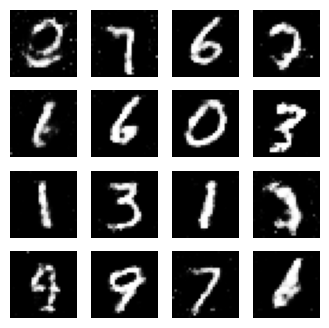

In [ ]:
noise = random.normal((16, 100))
generate_images(generator, generator_state, noise)

Would you look at that! Take that Yann, we got our own MNIST dataset now! :p

# Thank you!
Thanks for reading my article and following my code. If you found it helpful, please consider giving a star to my repo and liking my medium artcile!

Have a wonderful day! Happy building!